# Titanic Survival Prediction
This ML Model will be used to predict passenger survival based on the dataset from Kaggle (https://www.kaggle.com/competitions/titanic). In this approach, we will be using a Tensorflow/Keras DNN to perform predictions on the test.csv file after training with the supplied train.csv file.

In [23]:
#Importing Libraries/Modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Data Preprocessing

First, lets open the csv file and preview the data.

In [24]:
#CSV Filepath
train_data_path = 'Data/train.csv'
test_data_path = 'Data/test.csv'

train_data = pd.read_csv(train_data_path, delimiter=',')
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


There are 891 rows of training data. As seen from above, the data requires cleaning & preprocessing before it can be fed into a Neural Network. 

First, we will drop the columns which are not relevant to training:
- PassengerId: We do not require the Passenger Id for training our model since it is just an index.
- Name: The name of the passenger is not required as it has no impact on the result.
- Ticket: This is just the ticket number, again this should not have an impact on the result.
- Cabin: This may have an impact on the result, however there are a large number of rows without a cabin value (only 204 out of 890) so this will be discarded.


In [25]:
train_data = train_data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Now, we need to handle null values for the remaining columns:

In [26]:
train_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

From the output, it is evident that there are a significant number of rows without age. We have two options here - either discard null rows OR fill in the values using some statistical approaches like mean, mode etc. Since we only have around 800 rows of data, dropping ~170 rows would affect our training, so we will instead fill in with mean.
For the other column 'Embarked', we can just drop the rows since there are only 2 rows with missing data.

In [27]:
train_data = train_data.dropna(subset=['Embarked'])
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
train_data

/var/folders/94/j0q38tb53cddks5lvhm9vjlc0000gn/T/ipykernel_2607/1827510441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.642093,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


### Handling Categorical Values
For the columns with categorical values, we will perform one-hot encoding. Note that this is feasible only if the number of categories is not very large, because the cardinality of the dataset will increase. One-hot encoding is done to prevent the model from misinterpreting data (e.g. the model might think a pclass of 3 is greater than a pclass of 1)

In [28]:
#One-hot encoding the 'Sex' column
train_data = pd.concat([train_data, pd.get_dummies(train_data['Sex'])],axis=1)
#One-hot encoding the 'Pclass' column
train_data = pd.concat([train_data, pd.get_dummies(train_data['Pclass'], prefix='Pclass')],axis=1)
#One-hot encoding the 'Embarked' column
train_data = pd.concat([train_data, pd.get_dummies(train_data['Embarked'], prefix='Embarked')],axis=1)

#Dropping original columns since they are now encoded
train_data = train_data.drop(['Pclass','Sex','Embarked'], axis=1)
train_data

,Survived,Age,SibSp,Parch,Fare,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.000000,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.000000,1,0,53.1000,1,0,1,0,0,0,0,1
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,0,1,0,1,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,1,0,0,0,0,1
888,0,29.642093,1,2,23.4500,1,0,0,0,1,0,0,1
889,1,26.000000,0,0,30.0000,0,1,1,0,0,1,0,0


Now that the data has been cleaned, this will be our final dataset! The labels will be the first column (shape 888x1) and the input will be the remaining columns (input vector shape 888x12)

In [29]:
#Variables to store final vectors
train_input = []
train_labels = []
for index,row in train_data.iterrows() :
    #Append 1st column to labels
    train_labels.append(row['Survived'])
    #Append remaining columns to input
    train_input.append(row[1:])

#Convert to NP Arrays
train_input = np.asarray(train_input)
train_labels = np.asarray(train_labels)


## Building the Model
For this problem, we will be using a DNN model with the Keras Sequential API. The model architecture will comprise of:
- 1 Input Layer of 12 neurons
- 2 Hidden Layers of 12,6 neurons 
- 1 Output Layer of 1 neuron.

In [30]:
np.random.seed(173342) #Set seed for reproducability

model = tf.keras.models.Sequential([
    #Input Layer
    tf.keras.layers.Dense(12,input_shape=(None,12),activation="relu"),
    #1st Hidden Layer
    tf.keras.layers.Dense(12,activation="relu"),
    #2nd Hidden Layer
    tf.keras.layers.Dense(6,activation="relu"),
    #Output Layer which using sigmoid (because we just have two output classes)
    tf.keras.layers.Dense(1,activation="sigmoid")
])

#print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 12)          156       
                                                                 
 dense_5 (Dense)             (None, None, 12)          156       
                                                                 
 dense_6 (Dense)             (None, None, 6)           78        
                                                                 
 dense_7 (Dense)             (None, None, 1)           7         
                                                                 
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


### Training the Model
We will train the model for 200 epochs and a batch size of 20. The optimizer used will be Adam (default learning rate) with the Binary Cross-Entropy Loss function.

Epoch 1/200
 8/45 [====>.........................] - ETA: 0s - loss: 6.9444 - accuracy: 0.3812 

2022-07-22 10:42:40.490763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 1s 8ms/step - loss: 3.8548 - accuracy: 0.4106
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 0.7938 - accuracy: 0.6704
Epoch 3/200
45/45 [==============================] - 0s 8ms/step - loss: 0.6544 - accuracy: 0.6727
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 0.6170 - accuracy: 0.6828
Epoch 5/200
45/45 [==============================] - 0s 7ms/step - loss: 0.6131 - accuracy: 0.6738
Epoch 6/200
45/45 [==============================] - 0s 7ms/step - loss: 0.6011 - accuracy: 0.6884
Epoch 7/200
45/45 [==============================] - 0s 7ms/step - loss: 0.5960 - accuracy: 0.6828
Epoch 8/200
45/45 [==============================] - 0s 7ms/step - loss: 0.5910 - accuracy: 0.6895
Epoch 9/200
45/45 [==============================] - 0s 7ms/step - loss: 0.5844 - accuracy: 0.6850
Epoch 10/200
45/45 [==============================] - 0s 7ms/step - loss: 0.5785 - accuracy: 0.6828
Epoch 11/200
45/45 [=

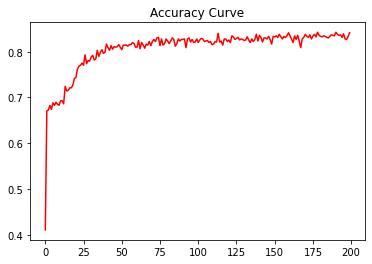

In [31]:
optimizer = tf.keras.optimizers.Adam()
lossFn = tf.keras.losses.BinaryCrossentropy()

#Compile the model
model.compile(loss=lossFn,optimizer=optimizer,metrics=["accuracy"])

#Training the model
history = model.fit(train_input,train_labels,epochs=200,batch_size=20)

#Plot the results
acc=history.history['accuracy']
epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r')
plt.title('Accuracy Curve')
plt.show()
print("")

Our model achieved an accuracy of about 83% after 200 epochs, which is quite good considering the amount of data we had! (also consider the missing values in the age column which were naively filled with the mean). However we also see that there was not much improvement after about 60 epochs and the accuracy hovered around 82-83%.

## Predicting the Results
Now that we have our trained model, we can perform the predictions on the final test set supplied from Kaggle (present in the Data/test.csv file). Again, we will have to preprocess/clean this file to make it the same shape as our model input vector.

In [32]:
#Reading the test.csv file
test_data = pd.read_csv(test_data_path,delimiter=",")
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [33]:
#Dropping columns
test_data = test_data.drop(["PassengerId","Name","Ticket","Cabin"],axis=1)
#Finding columns with null values
test_data.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

Since we cannot drop rows from our test data, both the Age and Fare missing values will be naively filled with the respective means. We will also one-hot encode the categorical values. Note that the order of the columns must be the same as our training input (since our model was trained with that specific order).

In [34]:
#Fill missing values with mean
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].mean())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())
#Convert categorical values to one-hot encoding
test_data = pd.concat([test_data, pd.get_dummies(test_data['Sex'])],axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Pclass'], prefix='Pclass')],axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Embarked'], prefix='Embarked')],axis=1)

#Dropping original columns since they are now encoded
test_data = test_data.drop(['Pclass','Sex','Embarked'], axis=1)
test_data

,Age,SibSp,Parch,Fare,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,34.50000,0,0,7.8292,0,1,0,0,1,0,1,0
1,47.00000,1,0,7.0000,1,0,0,0,1,0,0,1
2,62.00000,0,0,9.6875,0,1,0,1,0,0,1,0
3,27.00000,0,0,8.6625,0,1,0,0,1,0,0,1
4,22.00000,1,1,12.2875,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,30.27259,0,0,8.0500,0,1,0,0,1,0,0,1
414,39.00000,0,0,108.9000,1,0,1,0,0,1,0,0
415,38.50000,0,0,7.2500,0,1,0,0,1,0,0,1
416,30.27259,0,0,8.0500,0,1,0,0,1,0,0,1


This will be our final test data for prediction. The shape is 418x12 as seen from above. We will convert these to NumPy arrays and feed them into the model for prediction

In [35]:
test_input = []

for index,row in test_data.iterrows():
    #Append all columns to input
    test_input.append(row[:])

#Convert to NP Array
test_input = np.asarray(test_input)
test_input

array([[34.5       ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [47.        ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [62.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [38.5       ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [30.27259036,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [30.27259036,  1.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ]])

In [36]:
#Predicting the results
test_pred = model.predict(test_input)
test_final = (test_pred > 0.5).astype(int).reshape(test_input.shape[0])
test_final

14/14 [==============================] - 0s 3ms/step


2022-07-22 10:43:46.714948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Now that we have our predictions, we will output them into the a new CSV file with the passengerId column.

In [37]:
#read the original test data file again to get passengerIds
test_data = pd.read_csv(test_data_path,delimiter=",")
output = pd.DataFrame({'PassengerId':test_data['PassengerId'], 'Survived':test_final})
#Save the file
output.to_csv('Data/predictions.csv',index=False)
output['Survived'].value_counts()

0    280
1    138
Name: Survived, dtype: int64

## Conclusion
Our model has predicted 151 survivors out of the 418 rows of test data. After uploading the CSV to kaggle to check our score, we achieved about 77% accuracy. Further improvements could be done by changing the preprocessing methods (such as filling in missing values, dropping columns)

In [ ]:
# Saving the model
model.save('PredictionModel.h5')